# Загрузка данных с Kaggle

In [1]:
!pip install kaggle

In [2]:
import os
os.environ['KAGGLE_USERNAME'] = "kortana"
os.environ['KAGGLE_KEY'] = "a343264181f7e41c1b4ac43285fc2840"
!kaggle datasets download -d rajyellow46/wine-quality

  0% 0.00/98.0k [00:00<?, ?B/s]
100% 98.0k/98.0k [00:00<00:00, 53.8MB/s]


In [3]:
import zipfile
with zipfile.ZipFile('wine-quality.zip', 'r') as zip_ref:
    zip_ref.extractall('')

# Цель исследования, изучение и подготовка данных

Информация об атрибутах:

Для получения дополнительной информации прочтите [Cortez et al., 2009].
Входные переменные (на основе физико-химических тестов):

    1 - фиксированная кислотность
    2 - летучая кислотность
    3 - лимонная кислота
    4 - остаточный сахар
    5 - хлориды
    6 - свободный диоксид серы
    7 - общий диоксид серы
    8 - плотность
    9 - рН
    10 - сульфаты
    11 - спирт

Выходная переменная
(на основе сенсорных данных):

    12 - качество (оценка от 0 до 10)

Таким образом, целью исследования станет построение модели на основе характеристик вина для определения его качества. Изучим переменные.

In [55]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

In [5]:
df = pd.read_csv('winequalityN.csv')
df.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [83]:
df.groupby('quality').count()['type_red']

quality
3      30
4     216
5    2138
6    2836
7    1079
8     193
9       5
Name: type_red, dtype: int64

Наблюдаем пропуски по нескольким признакам, а также одна переменная представлена в виде строкового типа. Закодируем её. Видим сильную несбалансированность классов. Возможны проблемы с предсказанием 3 и 9 качества.

In [9]:
df = pd.get_dummies(df)

Проверим корреляцию и уберем незначимые признаки.

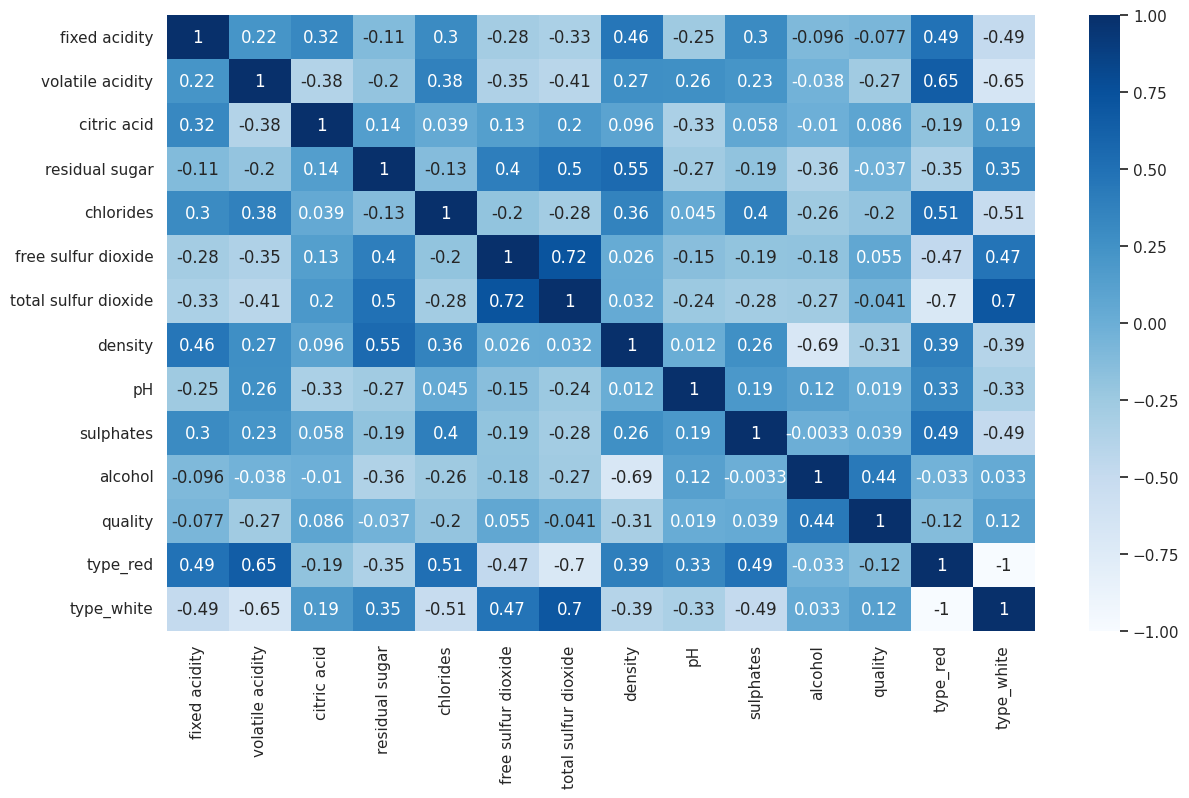

In [15]:
plt.figure(figsize=(14,8))
corr = df.corr()
heatmap = sns.heatmap(corr, annot=True, cmap="Blues")

По столбцу quality видим, что корреляция с признаками практически минимальная. Оставим все признаки, поскольку на основе нескольких будет сложно описать целевую переменную.

Заполним пропуски

In [22]:
print('Признаки с пропусками: ', df.columns[df.isna().sum(axis = 0)!=0])

Признаки с пропусками:  Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'pH', 'sulphates'],
      dtype='object')


Все признаки являются непрерывной переменной, поэтому пропуски заполним медианой, чтобы распределение данных не изменилось.

In [29]:
for col in df.columns[df.isna().sum(axis = 0)!=0]:
  df[col] = df[col].fillna(df[col].median())

In [30]:
#проверка
df.isna().sum(axis = 0)

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
type_red                0
type_white              0
dtype: int64

Проверим данные на выбрросы, построив распределение для каждого признака.

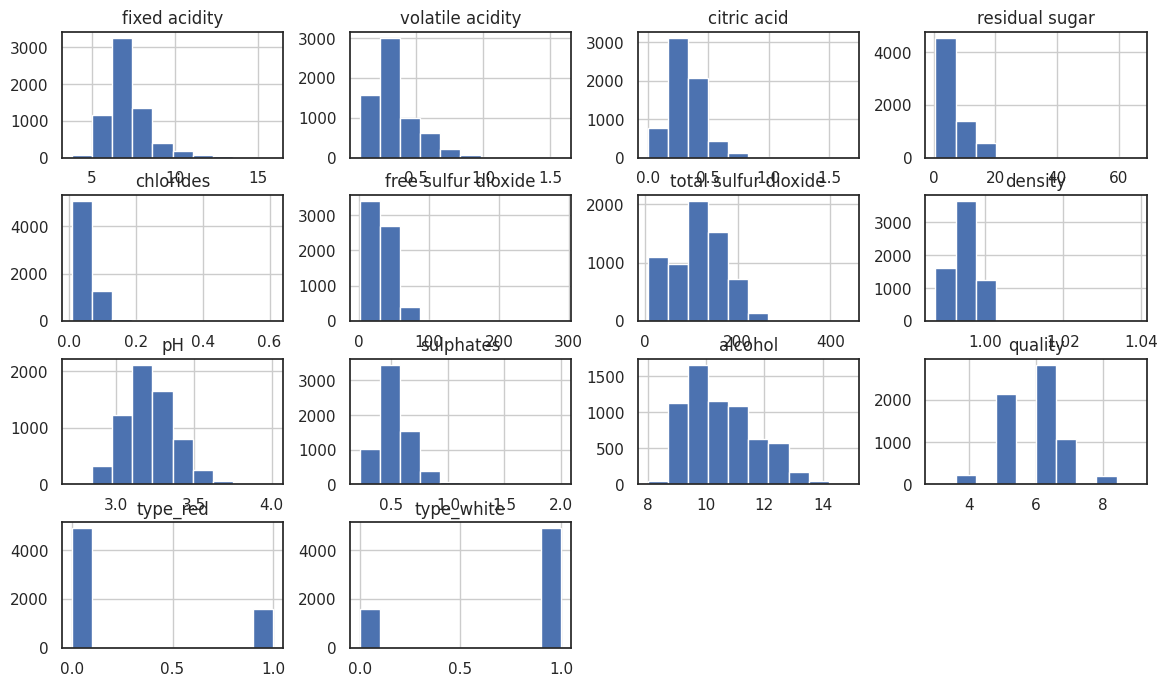

In [36]:
a = df.hist(figsize = (14,8))
plt.show()

Присутствуют небольшие выбросы у chlorides, sulphates, residual_sugar, однако они не являются критическими.

# Разделение данных на выборки и построение модели

In [101]:
X = df.drop(['quality'], axis = 1)
y = df['quality']

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 1)
y_train = y_train - 3 #приводим от оценки 3,4,..,9 к виду 0,1,...,6

In [107]:
model = xgb.XGBClassifier(n_estimators  = 100, max_depth  = 7)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [108]:
y_pred = model.predict(X_train)
accuracy_score(y_pred, y_train)

0.9991202990983066

In [110]:
y_pred = model.predict(X_test)+3
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         5
           4       0.36      0.13      0.20        60
           5       0.70      0.71      0.70       647
           6       0.64      0.72      0.68       837
           7       0.66      0.59      0.62       344
           8       0.54      0.27      0.36        56
           9       0.00      0.00      0.00         1

    accuracy                           0.66      1950
   macro avg       0.41      0.35      0.37      1950
weighted avg       0.65      0.66      0.65      1950



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Выводы

Видим, что присутствует переобучение модели, а также проблемы с предсказанием 3 и 9 класса, поскольку объектов данного класса очень мало в выборке. Таким обрахом, удалось построить первую модель для оценки качества вина, однако требуются изменения в моделе и устранение переобучение.